# Mod 4 Project - Starter Notebook

This notebook has been provided to you so that you can make use of the following starter code to help with the trickier parts of preprocessing the Zillow dataset. 

The notebook contains a rough outline the general order you'll likely want to take in this project. You'll notice that most of the areas are left blank. This is so that it's more obvious exactly when you should make use of the starter code provided for preprocessing. 

**_NOTE:_** The number of empty cells are not meant to infer how much or how little code should be involved in any given step--we've just provided a few for your convenience. Add, delete, and change things around in this notebook as needed!

# Some Notes Before Starting

This project will be one of the more challenging projects you complete in this program. This is because working with Time Series data is a bit different than working with regular datasets. In order to make this a bit less frustrating and help you understand what you need to do (and when you need to do it), we'll quickly review the dataset formats that you'll encounter in this project. 

## Wide Format vs Long Format

If you take a look at the format of the data in `zillow_data.csv`, you'll notice that the actual Time Series values are stored as separate columns. Here's a sample: 

<img src='~/../images/df_head.png'>

You'll notice that the first seven columns look like any other dataset you're used to working with. However, column 8 refers to the median housing sales values for April 1996, column 9 for May 1996, and so on. This This is called **_Wide Format_**, and it makes the dataframe intuitive and easy to read. However, there are problems with this format when it comes to actually learning from the data, because the data only makes sense if you know the name of the column that the data can be found it. Since column names are metadata, our algorithms will miss out on what dates each value is for. This means that before we pass this data to our ARIMA model, we'll need to reshape our dataset to **_Long Format_**. Reshaped into long format, the dataframe above would now look like:

<img src='~/../images/melted1.png'>

There are now many more rows in this dataset--one for each unique time and zipcode combination in the data! Once our dataset is in this format, we'll be able to train an ARIMA model on it. The method used to convert from Wide to Long is `pd.melt()`, and it is common to refer to our dataset as 'melted' after the transition to denote that it is in long format. 

# Helper Functions Provided

Melting a dataset can be tricky if you've never done it before, so you'll see that we have provided a sample function, `melt_data()`, to help you with this step below. Also provided is:

* `get_datetimes()`, a function to deal with converting the column values for datetimes as a pandas series of datetime objects
* Some good parameters for matplotlib to help make your visualizations more readable. 

Good luck!


# Step 1: Load the Data/Filtering for Chosen Zipcodes

In [31]:
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import adfuller

plt.style.use('seaborn-darkgrid')
%matplotlib inline

In [32]:
df = pd.read_csv('zillow_data.csv')
len(df)

14723

In [33]:
# Going to focus on 76001 (One of many Arlington TX Zips)
zip_code = 76051
df_zip = df.loc[df['RegionName'] == zip_code]

# Subset data for zip codes in Erie County NY with full data (1996 - 2018) 
# df.loc[(df['CountyName'] == 'Erie') & (df['State'] == 'NY') & (df['1996-04'])]

In [34]:
# df_Eden.drop(labels = ['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'], axis=1, inplace=True)

In [35]:
df_zip.drop(['RegionID', 'SizeRank'], axis=1, inplace=True)

C:\Users\dougl\Anaconda3\envs\learn-env\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


# Step 2: Data Preprocessing

In [36]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionName', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

In [37]:
df_zip = melt_data(df_zip)
df_zip

,value
time,
1996-04-01,188200.0
1996-05-01,189100.0
1996-06-01,190000.0
1996-07-01,190900.0
1996-08-01,191800.0
...,...
2017-12-01,334900.0
2018-01-01,333900.0
2018-02-01,336500.0


In [38]:
# def get_datetimes(df):
#     return pd.to_datetime(df.columns.values[1:], format='%Y-%m')

In [39]:
ts_zip = df_zip

ts_zip.index = pd.DatetimeIndex(ts_zip.index.values,
                               freq='MS')

# Create train and test set versions of one zip code time series
ts_zip_train = ts_zip[:'2015-04']
ts_zip_test = ts_zip['2015-05':]

# Step 3: EDA and Visualization

In [40]:
# font = {'family' : 'normal',
#         'weight' : 'bold',
#         'size'   : 22}

# matplotlib.rc('font', **font)

# NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!

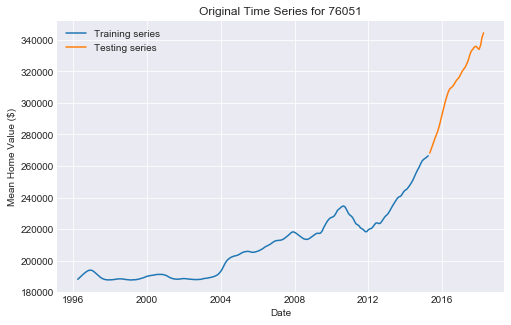

In [41]:
plt.figure(figsize=(8,5))
plt.plot(ts_zip_train, label='Training series')
plt.plot(ts_zip_test, label='Testing series')
plt.title(f'Original Time Series for {zip_code}')
plt.xlabel('Date')
plt.ylabel('Mean Home Value ($)')
plt.legend()
plt.show();


In [42]:
ts_zip.value.isna().sum()
ts_zip.describe()

,value
count,265.000000
mean,222885.660377
std,40749.098592
min,187800.000000
25%,190300.000000
50%,213000.000000
75%,232100.000000
max,344400.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000024CFCCBD438>]],
      dtype=object)

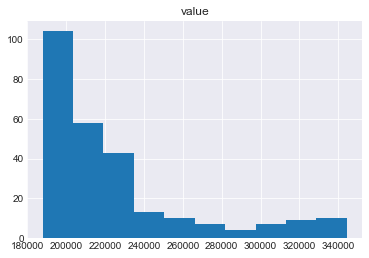

In [43]:
ts_zip.hist()

In [44]:
zip_ad_test = adfuller(ts_zip.value)

In [45]:
zip_ad_test # ad fuller test not signficant, time series is NOT stationary

(3.1624856713570253,
 1.0,
 4,
 260,
 {'1%': -3.4557539868570775,
  '5%': -2.8727214497041422,
  '10%': -2.572728476331361},
 3680.635779212396)

# Step 4: Reshape from Wide to Long Format

In [46]:
# already did this part in preprocessing

# Step 5: ARIMA Modeling

In [47]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0,4)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p,d,q))

# Generate all different combinations of seasonal p, q and q triplets (use 12 for frequency)
pdqs = [(x[0], x[1], x[2], 12) for x in pdq]

print(pdqs)

[(0, 0, 0, 12), (0, 0, 1, 12), (0, 0, 2, 12), (0, 0, 3, 12), (0, 1, 0, 12), (0, 1, 1, 12), (0, 1, 2, 12), (0, 1, 3, 12), (0, 2, 0, 12), (0, 2, 1, 12), (0, 2, 2, 12), (0, 2, 3, 12), (0, 3, 0, 12), (0, 3, 1, 12), (0, 3, 2, 12), (0, 3, 3, 12), (1, 0, 0, 12), (1, 0, 1, 12), (1, 0, 2, 12), (1, 0, 3, 12), (1, 1, 0, 12), (1, 1, 1, 12), (1, 1, 2, 12), (1, 1, 3, 12), (1, 2, 0, 12), (1, 2, 1, 12), (1, 2, 2, 12), (1, 2, 3, 12), (1, 3, 0, 12), (1, 3, 1, 12), (1, 3, 2, 12), (1, 3, 3, 12), (2, 0, 0, 12), (2, 0, 1, 12), (2, 0, 2, 12), (2, 0, 3, 12), (2, 1, 0, 12), (2, 1, 1, 12), (2, 1, 2, 12), (2, 1, 3, 12), (2, 2, 0, 12), (2, 2, 1, 12), (2, 2, 2, 12), (2, 2, 3, 12), (2, 3, 0, 12), (2, 3, 1, 12), (2, 3, 2, 12), (2, 3, 3, 12), (3, 0, 0, 12), (3, 0, 1, 12), (3, 0, 2, 12), (3, 0, 3, 12), (3, 1, 0, 12), (3, 1, 1, 12), (3, 1, 2, 12), (3, 1, 3, 12), (3, 2, 0, 12), (3, 2, 1, 12), (3, 2, 2, 12), (3, 2, 3, 12), (3, 3, 0, 12), (3, 3, 1, 12), (3, 3, 2, 12), (3, 3, 3, 12)]


In [48]:
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
results = []

# for i in pdq:
#     for j in pdqs:
#         model = sm.tsa.SARIMAX(ts_zip, order=i, seasonal_order=j, enforce_stationarity=False,
#                                  enforce_invertibility=False)
#         out = model.fit()
#         aic = out.aic
#         results.append([i, j, aic])
#         print([i, j, aic])
        
for i in pdq:
    model = sm.tsa.SARIMAX(ts_zip_train, order=i,enforce_stationarity=False,
                                 enforce_invertibility=False)
    out = model.fit()
    aic = out.aic
    results.append([i, aic])
    print([i, aic])

[(0, 0, 0), 6237.468939741]
[(0, 0, 1), 6046.840706885388]
[(0, 0, 2), 14397.347842533098]
[(0, 0, 3), 5946.293719717765]
[(0, 1, 0), 3705.601163097786]
[(0, 1, 1), 3445.5752581693837]
[(0, 1, 2), 3278.213475293796]
[(0, 1, 3), 3242.8361809645617]
[(0, 2, 0), 3299.2834447208415]
[(0, 2, 1), 3243.8867705612797]
[(0, 2, 2), 3222.1856268347806]
[(0, 2, 3), 3190.632477413584]
[(0, 3, 0), 3367.365672875692]
[(0, 3, 1), 3343.0693510110495]
[(0, 3, 2), 3225.331663325217]
[(0, 3, 3), 3213.929844382332]
[(1, 0, 0), 3675.3208149322763]
[(1, 0, 1), 3468.511210616007]
[(1, 0, 2), 3366.6600927481372]
[(1, 0, 3), 3368.129076342513]
[(1, 1, 0), 3304.5811841681143]
[(1, 1, 1), 3248.106905372162]
[(1, 1, 2), 3220.7269320462683]
[(1, 1, 3), 3194.9604204053057]
[(1, 2, 0), 3282.7379087510444]
[(1, 2, 1), 3236.9325660163604]
[(1, 2, 2), 3224.0753173323765]
[(1, 2, 3), 3188.880966387559]
[(1, 3, 0), 3368.4695640760665]
[(1, 3, 1), 3282.6119052851873]
[(1, 3, 2), 3219.9454713249224]
[(1, 3, 3), 3217.1745918

C:\Users\dougl\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



[(2, 1, 1), 3234.501419726511]
[(2, 1, 2), 3222.6050115345843]
[(2, 1, 3), 3190.4201118815454]
[(2, 2, 0), 3217.051822257891]
[(2, 2, 1), 3218.932678716339]
[(2, 2, 2), 3202.6108436844893]
[(2, 2, 3), 3181.774550518467]
[(2, 3, 0), 3264.159268288246]
[(2, 3, 1), 3264.8689154791455]
[(2, 3, 2), 3242.803742234194]
[(2, 3, 3), 3222.1289458423153]
[(3, 0, 0), 3262.4054210761233]
[(3, 0, 1), 3235.1181655435594]
[(3, 0, 2), 3234.4512222955723]


C:\Users\dougl\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[(3, 0, 3), 3220.046901851939]
[(3, 1, 0), 3211.4008723323277]
[(3, 1, 1), 3223.0738862721264]
[(3, 1, 2), 3215.4316966195292]
[(3, 1, 3), 3187.8402315454014]
[(3, 2, 0), 3199.064104484428]
[(3, 2, 1), 3203.9577862814285]


C:\Users\dougl\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[(3, 2, 2), 3212.600738729077]
[(3, 2, 3), 3184.2821545952775]
[(3, 3, 0), 3236.63964161967]
[(3, 3, 1), 3238.499390017344]
[(3, 3, 2), 3239.241518576918]
[(3, 3, 3), 3206.1397953723344]


C:\Users\dougl\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [49]:
# Find the parameters with minimal AIC value.
# results_df = pd.DataFrame(results, columns=['pdq', 'pdqs', 'aic'])
# min_result = results_df.loc[results_df['aic'].idxmin()]
# print(min_result)

results_df = pd.DataFrame(results, columns=['pdq', 'aic'])
min_result = results_df.loc[results_df['aic'].idxmin()]
print(min_result)

pdq    (2, 2, 3)
aic      3181.77
Name: 43, dtype: object


In [50]:
# best_model = sm.tsa.SARIMAX(ts_zip, order=min_result.pdq, seasonal_order=min_result.pdqs, enforce_stationarity=False,
#                                  enforce_invertibility=False)

best_model = sm.tsa.SARIMAX(ts_zip_train, order=min_result.pdq, enforce_stationarity=False,
                                 enforce_invertibility=False)

output = best_model.fit()
output.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  value   No. Observations:                  229
Model:               SARIMAX(2, 2, 3)   Log Likelihood               -1584.887
Date:                Mon, 13 Jan 2020   AIC                           3181.775
Time:                        10:47:16   BIC                           3202.218
Sample:                    04-01-1996   HQIC                          3190.027
                         - 04-01-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3667      0.092     -3.973      0.000      -0.548      -0.186
ar.L2         -0.2423      0.078     -3.087      0.002      -0.396      -0.088
ma.L1          0.8940      0.099      9.044      0.000       0.700       1.088
ma.L2          0.1767      0.114      1.555      0.120      -0.046       0.399
ma.L3         -0.2767      0.064     -4.347      0.000      -0.401      -0.152
sigma2      8.664e+04   6846.254     12.655      0.000    7.32e+04       1e+05
===================================================================================
Ljung-Box (Q):                       65.24   Jarque-Bera (JB):                19.78
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               8.54   Skew:                             0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

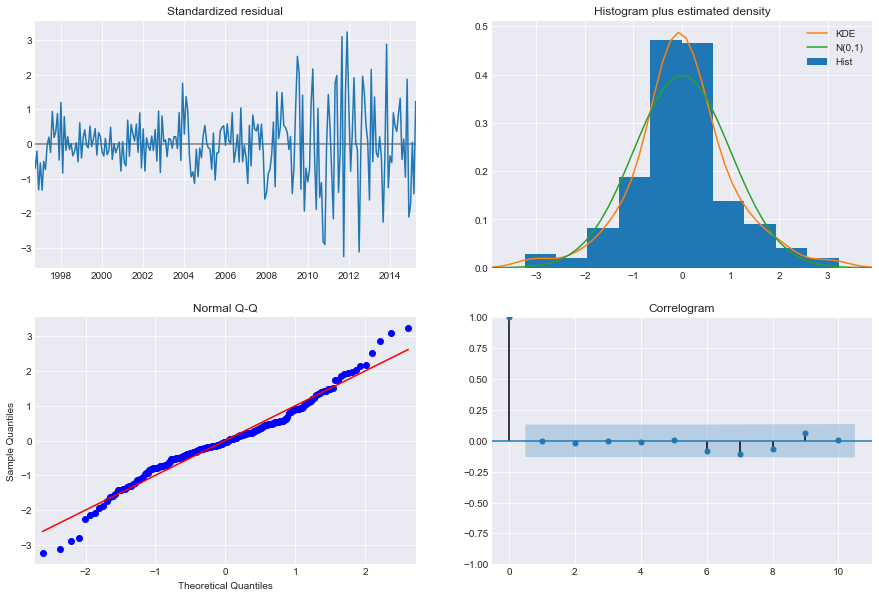

In [51]:
output.plot_diagnostics(figsize=(15,10));

In [52]:
# Forecast to end of 2021
pred_test = output.get_prediction(start='2015-05', end='2018-04')
pred_conf = pred_test.conf_int()

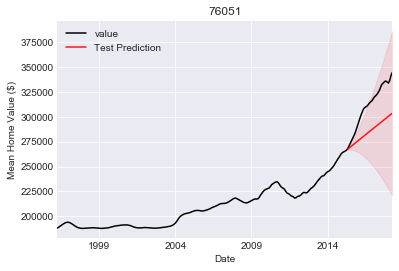

In [53]:
# Plot future predictions with confidence intervals
# fig = plt.figure(figsize=(15,6))

#Plot observed values

ax = ts_zip.plot(color='black')

#Plot predicted values
pred_test.predicted_mean.plot(ax=ax, label='Test Prediction', alpha=.9, color='red')

#Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='red', alpha=.1)

#Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Mean Home Value ($)')
plt.legend(loc=2)
plt.title(zip_code)

plt.show();

In [54]:
# Forecast model
fc_model = sm.tsa.SARIMAX(ts_zip, order=min_result.pdq, enforce_stationarity=False,
                                 enforce_invertibility=False)

fc_output = fc_model.fit()

In [55]:
forecast = fc_output.get_prediction(start='2018-05', end='2021-04')
fc_conf = forecast.conf_int()

<Figure size 1080x432 with 0 Axes>

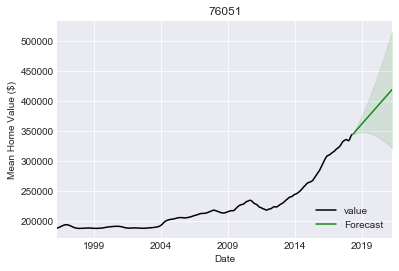

In [56]:
# Plot 3-year forecast with confidence intervals
fig = plt.figure(figsize=(15,6))

#Plot observed values
ax = ts_zip.plot(color='black')

#Plot predicted values
forecast.predicted_mean.plot(ax=ax, label='Forecast', alpha=.9, color='green')

#Plot the range for confidence intervals
ax.fill_between(fc_conf.index,
                fc_conf.iloc[:, 0],
                fc_conf.iloc[:, 1], color='green', alpha=.1)

#Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Mean Home Value ($)')
plt.legend(loc=4)
plt.title(zip_code)

plt.show()

In [57]:
# Calculate 3 year ROI for the forecast

# Initial value
init_val = ts_zip.value[-1]

# Final forecasted value after 3 year forecast
f_val = forecast.predicted_mean[-1]

ROI = round((f_val - init_val) / init_val, 3)

# Calculate lower & upper 95% confidence ROI values

# lower bound
l_f_val = fc_conf['lower value'][-1]

low_ROI = round((l_f_val - init_val) / init_val, 3)

# upper bound
u_f_val = fc_conf['upper value'][-1]

high_ROI = round((u_f_val - init_val) / init_val, 3)

# Size of 95% CL

size_cl = high_ROI - low_ROI

ROI_summary = pd.DataFrame(columns = ['Zip Code', 'Forecast ROI (%)', 'L 95 ROI (%)', 'H 95 ROI (%)', '95 CL Size (%)'])

ROI_summary = ROI_summary.append({'Zip Code': str(zip_code), 'Forecast ROI (%)': ROI*100, 'L 95 ROI (%)': low_ROI*100, 
                                  'H 95 ROI (%)': high_ROI*100, '95 CL Size (%)': size_cl*100}, ignore_index=True)

ROI_summary

,Zip Code,Forecast ROI (%),L 95 ROI (%),H 95 ROI (%),95 CL Size (%)
0,76051,21.7,-6.7,50.2,56.9


In [58]:
# Model prediction performance on test data
y_hat_test = pred_test.predicted_mean.values

y_test = ts_zip_test.values.ravel()

# MAPE : Mean Absolute Percentage Error
mape = round(np.sum(abs((np.subtract(y_test, y_hat_test) / y_test))) / len(y_test), 3)

# R^2 Score
from sklearn.metrics import r2_score

r2 = round(r2_score(y_test, y_hat_test), 3)

model_val_summary = pd.DataFrame(columns = ['Zip Code', 'MAPE (%)', 'R^2'])

model_val_summary = model_val_summary.append({'Zip Code': str(zip_code), 'MAPE (%)': mape*100, 'R^2': r2}, ignore_index=True)

model_val_summary

,Zip Code,MAPE (%),R^2
0,76051,8.0,-0.66


# Step 6: Interpreting Results

In [59]:
# Calcu